In [6]:
import pandas as pd
import numpy as np
import os,sys 
import matplotlib 
import matplotlib.pyplot as plt
import load.wsk_interact as wsk

In [7]:
# Read the two CSVs
# For each function: make a list of its invocation times?
# Compare these metrics in some way and visualize. Sort by function frequency? 

In [8]:
pp='./run-scripts/logs/compare-algos/'
f1='5.5-18-BoundedLoad-SimpleLoad/latencies.csv'
f2='5.5-18-ConsistentCache-SimpleLoad/latencies.csv'
f3='5.5-18-ConsistentHash-SimpleLoad/latencies.csv'
f4='10-mins-5.5-18-MemoryShard/latencies.csv'


In [9]:
out=[]
tmp = pd.read_csv(os.path.join(pp, f1))
func_names = tmp["lambda"].unique()
for warm_time, k in zip(wsk.warm_times, wsk.actions):
  for name in func_names:
    if k in name:
      out.append((name,warm_time))


In [10]:
warm_times = pd.DataFrame(out,columns=['lambda',"warm"])

In [11]:
def mean_lats_per_fn(expf):
    df = pd.read_csv(os.path.join(pp, expf), header=0, names=["lambda", "was_cold", "latency", "activationid"])
    ldf = df[['lambda', 'latency']]
    lgrps = ldf.groupby(['lambda'])
    #Also need the length of the list for correct normalization? 
    mean_lats = lgrps.mean()
    return mean_lats, lgrps, ldf, df 

In [12]:
def cmp_lats(f1, f2):
    """ Given two configs, compare the raw mean latencies for each function """
    m1 = mean_lats_per_fn(f1)[0]
    m2 = mean_lats_per_fn(f2)[0]
    merged = m1.merge(m2,on='lambda')
    merged['ldiff'] = pd.Series(merged['latency_y']-merged['latency_x'], index=merged.index)
    return merged 

In [13]:
def Wnorms(expf):
    mean_lats, lgrps, ldf, df = mean_lats_per_fn(expf)
    mean_warm = mean_lats.merge(warm_times,on='lambda')
    mean_warm['norm'] = pd.Series(mean_warm['latency']/mean_warm['warm'], index=mean_warm.index)
    
    counts = lgrps.count()
    counts = counts.rename(columns={'latency':'counts'})
    mean_warm = mean_warm.merge(counts, on='lambda')
    C=sum(mean_warm['counts'])
    mean_warm['Wnorm']=pd.Series(mean_warm['norm']*mean_warm['counts']/C, index=mean_warm.index)
    
    return mean_warm
    #sum(mean_warm['Wnorm'])

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

In [15]:
bounded=Wnorms(f1)
sum(bounded['Wnorm'])

6431.817119646426

In [16]:
ch_hash=Wnorms(f3)
#np.sort(np.array(b['Wnorm']))
sum(ch_hash['Wnorm'])

779.9571775240262

In [17]:
cache=Wnorms(f2)
#np.sort(np.array(b['Wnorm']))
sum(cache['Wnorm'])

972.8167052724796

In [18]:
mem_shard=Wnorms(f4)
#np.sort(np.array(b['Wnorm']))
sum(mem_shard['Wnorm'])

1342.4410728696448

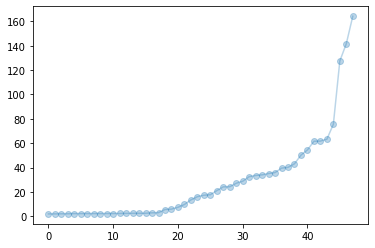

In [19]:
r2_ch_rl = bounded['Wnorm']/cache['Wnorm']
plt.plot(sorted(r2_ch_rl),marker='o',alpha=0.3)

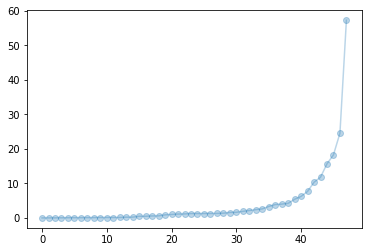

In [20]:
r2_ch_rl = mem_shard['Wnorm']/cache['Wnorm']
plt.plot(sorted(r2_ch_rl),marker='o',alpha=0.3)

In [21]:
r2_ch_rl[r2_ch_rl<1.0]

1     0.069565
2     0.888528
5     0.126102
10    0.600205
14    0.216063
15    0.096730
16    0.124502
19    0.478109
20    0.128424
22    0.014158
23    0.117319
27    0.074707
29    0.478866
31    0.024375
35    0.006312
37    0.087746
39    0.058876
40    0.575966
42    0.038167
44    0.231681
Name: Wnorm, dtype: float64

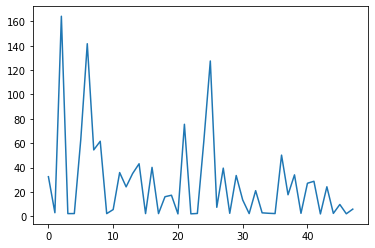

In [22]:
plt.plot((bounded['norm'])/(cache['norm']))